In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_excel('114.xls') 
years = df.iloc[:, 0].values  
data = df.iloc[:, 1:].values  


X = df[['MD', 'CSDA', 'MH', 'WFL', 'LT']]
y = df['HFWCZ']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


def eval_model(params):
    model = xgb.XGBRegressor(
        max_depth=int(params[0]),
        learning_rate=params[1],
        n_estimators=int(params[2]),
        subsample=params[3],
        colsample_bytree=params[4]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

class SparrowSearchAlgorithm:
    def __init__(self, pop_size, dim, lb, ub, max_iter, eval_func):
        self.pop_size = pop_size
        self.dim = dim
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.max_iter = max_iter
        self.eval_func = eval_func
        self.population = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        self.fitness = np.zeros(self.pop_size)
        self.global_best = None
        self.global_best_fitness = np.inf

    def run(self):
        for iter in range(self.max_iter):
            for i in range(self.pop_size):
                self.fitness[i] = self.eval_func(self.population[i])
                if self.fitness[i] < self.global_best_fitness:
                    self.global_best_fitness = self.fitness[i]
                    self.global_best = self.population[i].copy()

            for i in range(self.pop_size):
                r1 = np.random.rand()
                r2 = np.random.rand()
                if r2 < 0.8:
                    self.population[i] = self.global_best + r1 * (self.ub - self.lb) * np.random.randn(self.dim)
                else:
                    self.population[i] = self.lb + (self.ub - self.lb) * np.random.rand(self.dim)

            self.population = np.clip(self.population, self.lb, self.ub)

        return self.global_best


ssa = SparrowSearchAlgorithm(
    pop_size=10,
    dim=5,
    lb=[3, 0.01, 50, 0.5, 0.5],  # 参数下界
    ub=[10, 0.3, 300, 1.0, 1.0], # 参数上界
    max_iter=5,
    eval_func=eval_model
)


best_params = ssa.run()
print("best: ", best_params)


model = xgb.XGBRegressor(
    max_depth=int(best_params[0]),
    learning_rate=best_params[1],
    n_estimators=int(best_params[2]),
    subsample=best_params[3],
    colsample_bytree=best_params[4]
)


model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)


mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


print(f"train MSE: {mse_train:.4f}")
print(f"train RMSE: {rmse_train:.4f}")
print(f"train MAE: {mae_train:.4f}")
print(f"train R2: {r2_train:.4f}")


y_train = y_train.values  
y_val = y_val.values  
y_train_pred = np.array(y_train_pred)  
y_val_pred = model.predict(X_val)  

D:\Anaconda\Anaconda3-2020.07\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


优化后的参数:  [4.81681303e+00 9.88046271e-02 1.66322902e+02 6.32457640e-01
 8.84973838e-01]
训练集 MSE: 2.2166
训练集 RMSE: 1.4888
训练集 MAE: 1.1066
训练集 R2: 0.9981


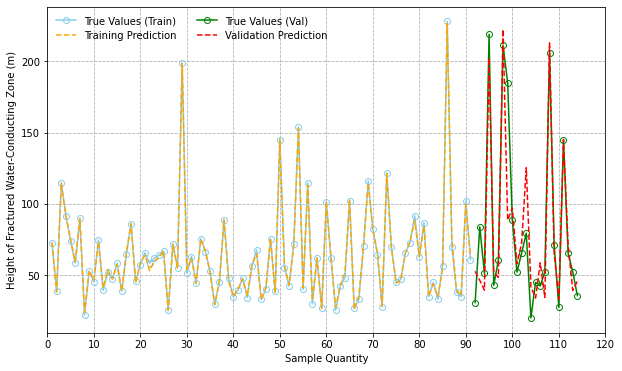

In [2]:

plt.figure(figsize=(10, 6))


train_index = np.arange(1, len(y_train) + 1)
plt.plot(train_index, y_train, 'o-', label="True Values (Train)", color='skyblue', markerfacecolor='none')
plt.plot(train_index, y_train_pred, '--', label="Training Prediction", color="#FFA500")


val_index = np.arange(len(y_train) + 1, len(y_train) + len(y_val) + 1)
plt.plot(val_index, y_val, 'o-', label="True Values (Val)", color='green', markerfacecolor='none')
plt.plot(val_index, y_val_pred, '--', label="Validation Prediction", color='red')


plt.xlim([0, 120])
plt.xticks(np.arange(0, 121, 10))

plt.xlabel('Sample Quantity')
plt.ylabel('Height of Fractured Water-Conducting Zone (m)')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=False, ncol=2)

plt.grid(True, linestyle='--')


plt.savefig('fig/ssa-xgboost.png', dpi=300)
plt.savefig('fig/ssa-xgboost.pdf', dpi=600, format='pdf')  # Save each plot
plt.show()

In [ ]:

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

plt.figure(figsize=(8, 4))
shap.summary_plot(shap_values, X_test, show=False)

plt.xlabel('SHAP Value', family='Times New Roman', fontsize=12)
plt.ylabel('Feature', family='Times New Roman', fontsize=12)

plt.xticks(fontname='Times New Roman', fontsize=12)
plt.yticks(fontname='Times New Roman', fontsize=12)

plt.savefig('fig/ssa-xgboost-shap_summary_plot.png', dpi=600)

plt.savefig('fig/ssa-xgboost-shap_summary_plot.pdf', dpi=600, format='pdf')
plt.show()


shap.plots.bar(shap_values)



mean_shap_values = np.abs(shap_values.values).mean(axis=0)


feature_names = X_test.columns
sorted_indices = np.argsort(mean_shap_values)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_shap_values = mean_shap_values[sorted_indices]


plt.figure(figsize=(10, 4))
bars = plt.barh(sorted_features, sorted_shap_values, color='skyblue')


plt.xlabel('Importance', family='Times New Roman', fontsize=12)
plt.ylabel('Feature', family='Times New Roman', fontsize=12)
plt.xticks(fontname='Times New Roman', fontsize=12)
plt.yticks(fontname='Times New Roman', fontsize=12)
plt.title('Feature Importance', family='Times New Roman', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)


plt.gca().invert_yaxis()


plt.xlim(0, 14)


for bar in bars:
    plt.text(
        bar.get_width() + 0.005,  
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.4f}',  
        va='center',
        family='Times New Roman', 
        fontsize=11
    )


plt.subplots_adjust(left=0.2)

plt.savefig('fig/ssa-xgboost-feature_importance.png', dpi=600)
plt.savefig('fig/ssa-xgboost-feature_importance.pdf', dpi=600, format='pdf')
plt.show()
